Your goal is to perform a sensitivity analysis of the parameters in the fly clock model of Goldbeter. The base project is about determining how consistent the sensitivities are across parameter sets. I would love to see extensions that examine which processes have which effects.

## Instructions
<ol>
<li> Use your genetic algorithm to generate 10 excellent parameter sets (i.e. run the algorithm 10 times and use the lowest cost child from each run). You may use parameter sets you found in Project 4 or you may generate new parameter sets.
<li> For each of the parameter sets, analyze the sensitivity of the amplitude and of the period (separately) to each parameter. To analyze the sensitivity of the amplitude, you will need to choose which state variable to focus on, or use the sensitivity of the sum of the amplitudes. Analyzing the amplitude sensitivities of multiple states and comparing the results is an extension.
<li> What are the similarities and differences in sensitivity across parameter sets? Are there parameters that have opposite effects in different parameter sets? 
</ol>
    
## Extensions
<ol>
<li> Analyze additional models
<li> Explore the effects of changing the size of the perturbation used to compute the sensitivities.
<li> Include an analysis of the sensitivity of state dynamics to parametric perturbation.
</ol>

## Steps to get you started

### 1. Copy-paste code and/or results from Project 4
You will need the Golbeter's model and get_period at the very least. If you are generating parameter sets in this project, you will also need the GA code and cost function. If you using parameter sets from Project 4, you can just refer to the files that have them (assuming you have .npz file).


Truncation Simulation

Run : 1
Run : 2
Run : 3
Run : 4
Run : 5
Run : 6
Run : 7
Run : 8
Run : 9
Run : 10


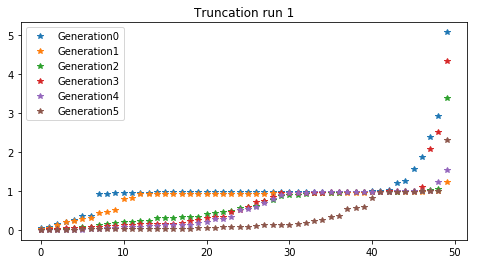

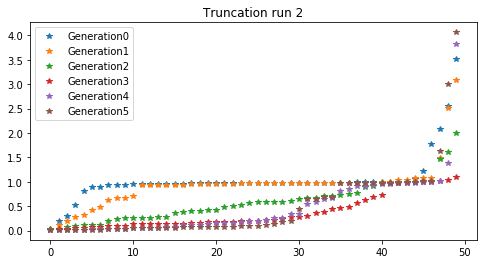

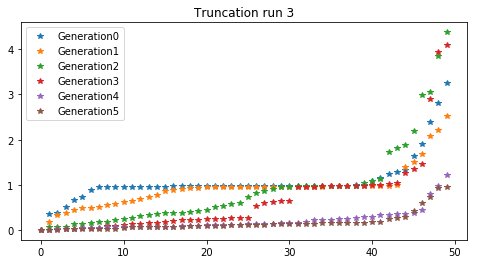

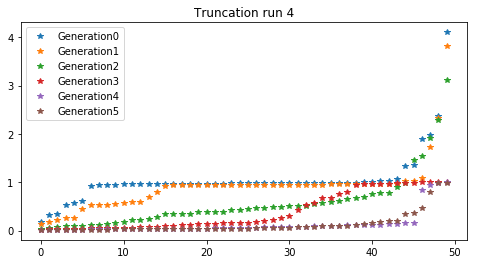

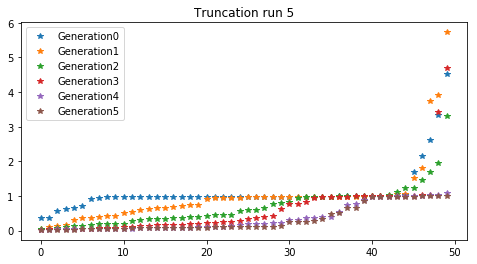

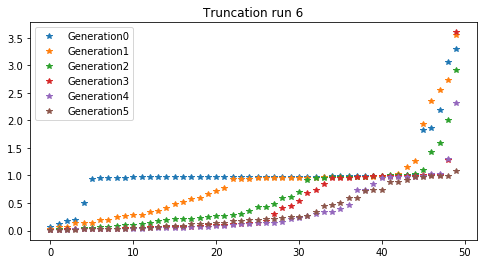

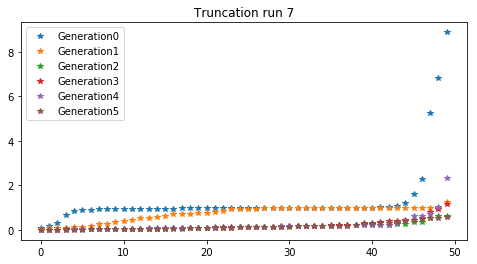

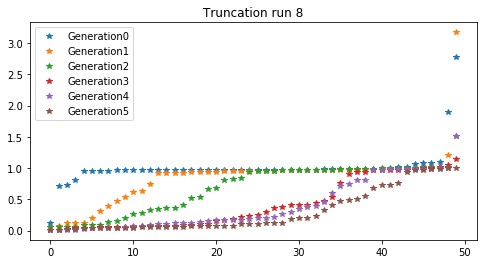

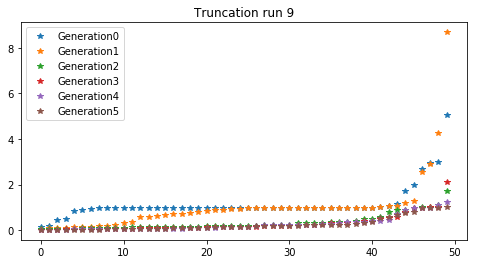

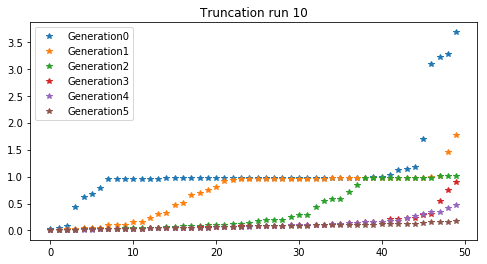

In [1]:
import numpy as np
import scipy.integrate
import scipy.signal

def negative_feedback(t, statevars, params):
    M = statevars[0]
    P0 = statevars[1]
    P1 = statevars[2]
    P2 = statevars[3]
    PN = statevars[4]
    PT = statevars[5]

    vs = params[0]
    vm = params[1]
    Km = params[2]
    ks = params[3]
    vd = params[4]
    k1 = params[5]
    k2 = params[6]
    KI = params[7]
    Kd = params[8]
    n = params[9]
    K1 = params[10]
    K2 = params[11]
    K3 = params[12]
    K4 = params[13]
    V1 = params[14]
    V2 = params[15]
    V3 = params[16]
    V4 = params[17]

    dydt = np.zeros( (6,) )
    dydt[0] = ( vs * ((KI**n)/(KI**n + PN**n)) ) - ( vm * ((M)/(Km + M)) )
    dydt[1] = ks*M - (V1 * ((P0)/(K1+P0))) + (V2 * ((P1)/(K2+P1)))
    dydt[2] = (V1*((P0)/(K1+P0))) - (V2*((P1)/(K2+P1))) - (V3*((P1)/(K3+P1))) + (V4*((P2)/(K4+P2)))
    dydt[3] = (V3*((P1)/(K3+P1))) - (V4*((P2)/(K4+P2))) - (k1*P2) + (k2*PN) - (vd*((P2)/(Kd+P2)))
    dydt[4] = (k1*P2) - (k2*PN)
    dydt[5] = dydt[1]+dydt[2]+dydt[3]+dydt[4]
    return dydt

def get_period(arr,t):
    peaks, _ = scipy.signal.find_peaks(arr)
    #print(peaks)
    time = []
    for peak in peaks:
        time.append(t[peak])
    periods = []
    #print(time)
    for i in range(len(time)-1,0,-1):
        periods.append(time[i] - time[i-1])
        
    return (np.mean(periods), np.std(periods))
def simulate_fly(params):
    initial = (1,1,1,1,1,1)
    nf = lambda t,y : negative_feedback(t, y, params)
    sol1 = scipy.integrate.solve_ivp(fun=nf, t_span=(0,240), y0=initial, t_eval=np.arange(0,240,0.01))
    sol2 = scipy.integrate.solve_ivp(fun=nf, t_span=(0,240), y0=sol1.y[:,-1], t_eval=np.arange(0,240,0.01), rtol=1e-8)
    return sol2

def gol95_cost(params):
    sol2 = simulate_fly(params)
    (per, sdper) = get_period(sol2.y[0,:], sol2.t)
    #print(per, sdper)
    #per = get_period(sol2.y[1,:], sol2.t)
    #sdper = np.std(per)
    return np.sqrt( ((per-23.6)/23.6)**2 + sdper/23.6 )

# vs = 0.76
# vm = 0.65
# Km = 0.5
# ks = 0.38
# vd = 0.95
# k1 = 1.9
# k2 = 1.3
# KI = 1
# Kd = 0.2
# n = 4
# K1 = 2
# K2 = 2
# K3 = 2
# K4 = 2
# V1 = 3.2
# V2 = 1.58
# V3 = 5
# V4 = 2.5
# params = (vs, vm , Km, ks, vd, k1, k2, KI, Kd, n, K1, K2, K3, K4, V1, V2, V3, V4)

# print(gol95_cost(params))

# Test your cost function here.
# When Stephanie tests hers with the parameters from Project 2, her cost is
# 0.0027454617448506194

import matplotlib.pyplot as plt
import numpy as np

class GASettings:
    def __init__( self, numParents = 10, numChildren = 50 ):
        self.numParents = numParents;
        self.numChildren = numChildren;
        self.numGenerations = 5;
        self.selection = 'truncation'; 
        self.slope = 15; # for linear ranking selection
        self.tournamentSize = 2;
        self.crossover = 'uniform';
        self.mutation = 0.05; # std of normal distribution computed as mutation*value
        self.eliteCount = 1;
        self.linearRankingRatio = 4;

def select_pool( G, Gcost, settings ):
    if Gcost.size != settings.numChildren:
        print("problem")
        return
    P = np.zeros( (settings.numParents,G.shape[1]) )
    Pcost = np.zeros( (settings.numParents,) )
    Pidxs = []
    if settings.selection == 'truncation':
        for i in range(settings.numParents):
            idx = np.random.choice(settings.numParents)
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == 'uniform':
        for i in range(settings.numParents):
            idx = np.random.choice(G.shape[0])
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == "tournament":
        for i in range(settings.numParents):
            idx = (np.random.choice(G.shape[0], (settings.tournamentSize,))).min() #we are looking through indexes here
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == "linearRanking":
        r = settings.linearRankingRatio
        n = settings.numChildren
        pn = 2/n*(1/(1+r))
        p1 = r*pn
        ps = np.zeros((n,))
        for i in range(1,n+1):
            ps[i-1] = pn + (p1-pn)*(n-i)/(n-1)
        cs = ps.cumsum()

        for i in range( settings.numParents ):
            num = np.random.random() # number between 0 and 1, from uniform distribution
            idx = np.argmax( num < cs )
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == "proportional":
        n = settings.numChildren

        sumCost = np.sum(Gcost[:n])
        ps = np.zeros((n,))
        for i in range(len(ps)):
            ps[i] = Gcost[i]/sumCost
        cs = ps.cumsum()
        cs = 1 - cs
        cs.sort()
        for i in range(settings.numParents):
            num = np.random.random()
            idx = np.argmax(num<cs)
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    else:
        print("Unknown selection operator: ", settings.selection)
    return (P, Pcost)

# Write your code for testing cross-over and mutation here.
def generateChild(cost_fcn, P, lb, ub, settings):
    params = np.zeros(lb.shape)
    cost   = np.inf
    for i in range(1000):
        P1idx = np.random.choice(P.shape[0])#pick a parent
        P1  = P[P1idx,:]#chooses that parent
        P2idx = np.random.choice(P.shape[0])#picks another
        P2  = P[P2idx,:]#chooses and locks second
        for j in range(lb.size):
            if np.random.random() < 0.5:
                params[j] = P1[j]
            else:
                params[j] = P2[j]
        #50% to get one trait from one, and 50 for other
        # Mutate optimization variables
        params = np.multiply( 1+np.random.randn(params.size)*settings.mutation, params)#mutation
        # Make sure the mutation hasn't moved us out of bounds
        params = np.maximum(params,lb)#bigger of what it is and the lower bound
        params = np.minimum(params,ub)#smaller of what it is and upper bound
        cost   = cost_fcn(params) # same cost function area as before

        if np.isfinite(cost):
            return ( params, cost )
    return (np.zeros((lb.size)), np.inf)
# Your GA code goes here! Copy-paste the simple island cost function from the Jupyter notebook from class.
def generateIndividual(cost_fcn, lb,ub):
    params = np.zeros(lb.shape);
    cost   = np.inf;
    for i in range( 1000 ):
        params = lb + np.multiply( np.random.random(lb.size), ub-lb);
        cost   = cost_fcn(params);
        if np.isfinite(cost):
            return (params, cost);
    return (params, np.inf)

def GA(cost_fcn, lb, ub, settings):
    mu = settings.numParents;
    lam = settings.numChildren;
    numGenerations = settings.numGenerations;

    # Create initial population
    G = np.zeros( (lam,lb.size) );
    Gcost = np.zeros( (lam,) );
    for i in range(lam):
        (G[i,:], Gcost[i]) = generateIndividual(cost_fcn, lb, ub);
    # sort them by cost
    idx   = np.argsort(Gcost);
    Gcost = Gcost[idx]
    G     = G[idx,:];
    all_params = [G]
    all_costs = [Gcost]

    for g in range(numGenerations):
        # Promote any elites
        elites = G[:settings.eliteCount,:]
        eliteCosts = Gcost[:settings.eliteCount]
        # select breeding pool\
        (P, Pcost) = select_pool( G, Gcost, settings )
        # Generate the children for generation g
        G = np.zeros((lam, lb.size));
        Gcost = np.zeros((lam,));
        G[:settings.eliteCount,:] = elites
        Gcost[:settings.eliteCount] = eliteCosts
        for i in range(settings.eliteCount,lam):
           (G[i,:], Gcost[i]) = generateChild(cost_fcn, P, lb, ub, settings);
        # sort the children of this generation
        idx   = np.argsort(Gcost);
        Gcost = Gcost[idx]
        G     = G[idx,:];
        costMean = np.mean(Gcost)
        print('Best of generation ', g+1, ' has cost ', Gcost[0]);
        #print('Generation ', g+1, ' has a mean cost of ', costMean)
        all_params.append(G)
        all_costs.append(Gcost)

    params = G[0,:];
    cost   = Gcost[0];
    return (params, cost, all_params, all_costs)

lb = np.zeros((18,));
ub = np.zeros((18,));
lb[0] = 0;   ub[0] = 1;# vs = 0.76;
lb[1] = 0;   ub[1] = 1;# vm = 0.65;
lb[2] = .1;  ub[2] = 1;# Km = 0.5;
lb[3] = 0;   ub[3] = 1;# ks = 0.38;
lb[4] = 0;   ub[4] = 1;# vd = 0.95;
lb[5] = 0;   ub[5] = 2;# k1 = 1.9;
lb[6] = 0;   ub[6] = 2;# k2 = 1.3;
lb[7] = 1;   ub[7] = 1;# KI = 1;
lb[8] = 0.1; ub[8] = 1;# Kd = 0.2;
lb[9] = 4;  ub[9] = 4;# n = 4;
lb[10] = 0.5;  ub[10] = 2.5;# K1 = 2;
lb[11] = 0.5;  ub[11] = 2.5;# K2 = 2;
lb[12] = 0.5;  ub[12] = 2.5;# K3 = 2;
lb[13] = 0.5;  ub[13] = 2.5;# K4 = 2;
lb[14] = 0;  ub[14] = 5;# V1 = 3.2;
lb[15] = 0;  ub[15] = 5;# V2 = 1.58;
lb[16] = 0;  ub[16] = 5;# V3 = 5;
lb[17] = 0;  ub[17] = 5;# V4 = 2.5;
print("\nTruncation Simulation\n")
# GA with truncation selection, an elite count of 1, 10 parents, 50 children, and a mutation scale of 0.05
settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 5 #for all
settings.eliteCount = 1
settings.selection = 'truncation'
settings.mutation = 0.05
#runList = []
good_params = []
for x in range(1,11):
    print('Run :', x)
    fn = "Fly_Clock_Truncation_run%d.npz" % (x)
    # if os.path.isfile( fn ):
    #     continue
    #this is for getting the files
    #(params, cost, all_params, all_costs) = GA(gol95_cost, lb, ub, settings)
    #this if for making the files
    #np.savez( fn, params=params, cost=cost, all_params=all_params, all_costs=all_costs )
    #runList.append(params)

    #this is for grabbing files back
    f = np.load( fn, allow_pickle=True )
    all_costs = f['all_costs']
    all_params = f['all_params']
    params = f['params']
    good_params.append(params)
    plt.figure( figsize=(8,4) )
    legs = []
    for i in range(len(all_costs)):
        plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
        legs.append( "Generation" + str(i) )
    plt.title("Truncation run " + str(x))
    plt.legend( legs );

#figure out add to npz for runtime
    # plt.figure( figsize=(8,4) )
    # legs = []
    # for i in range(len(all_costs)):
    #     plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
    #     legs.append( "Generation" + str(i) )
    # plt.title("Truncation run " + str(x))
    # plt.legend( legs );"

 

### 2. Write the output functions you want to analyze.
<ol>
<li>Write a function that takes as input the parameters and provides as output the period.
<li>Write a function that takes as input the parameters and provides as output a measurement of the peak-to-trough amplitude. Here is where you can make a decision. You can track the amplitude of one particular state, or sum the amplitudes of all 5 states. In your report, be sure to clearly indicate which you chose.
</ol>

Test them with the published parameters. My output is
<code>
period 23.662222222222223
amplitude of M 2.3759648547322616
amplitude of P0 1.4260629330956047
amplitude of P1 0.7354556871287586
amplitude of P2 0.7550101535148619
amplitude of PN 1.0799752338320783
sum of amplitudes of all states 6.372468862303565</code>

Note: Make sure you run the model for at least 10 days, to eliminate the transient. Then run it again to determine the period or amplitude.

In [7]:
def get_fly_period(params):
    sol = simulate_fly(params)
    
    return get_period(sol.y[0,:], sol.t)[0]
    
def get_amplitude( params, which_state=-1 ):
    """ Return the amplitude of the given state or of the sum of all states
    If which_state  == -1, then return the sum
    """
    sol = simulate_fly( params )
    if which_state == -1:
        return np.sum(sol.y.max(axis=1)-sol.y.min(axis=1))
    else:
        return sol.y[which_state,:].max() - sol.y[which_state,:].min()

vs = 0.76
vm = 0.65
Km = 0.5
ks = 0.38
vd = 0.95
k1 = 1.9
k2 = 1.3
KI = 1
Kd = 0.2
n = 4
K1 = 2
K2 = 2
K3 = 2
K4 = 2
V1 = 3.2
V2 = 1.58
V3 = 5
V4 = 2.5
params = (vs, vm, Km, ks, vd, k1, k2, KI, Kd, n, K1, K2, K3, K4, V1, V2, V3, V4)
param_names = ("vs", "vm", "Km", "ks", "vd", "k1", "k2", "KI", "Kd", "n", "K1", "K2", "K3", "K4", "V1", "V2", "V3", "V4")
print(get_fly_period(params))
print(get_amplitude(params,0))#M
print(get_amplitude(params,1))#P0
print(get_amplitude(params,2))#P1
print(get_amplitude(params,3))#P2
print(get_amplitude(params,4))#Pn
print(get_amplitude(params,5))#unknown
print(get_amplitude(params))#all

23.662222222222223
2.375966613896488
1.4260645992025112
0.735456545602436
0.7550111200661321
1.0799769471341882
3.47809761865415
9.850573444555906


### 3. Write the sensitivity analysis code and test it.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import scipy.linalg
import scipy.integrate
import scipy.signal
import matplotlib.cm

def sensitivity( fcn, ref_params, frac_change ):
    """
    fcn should be a handle to a function that takes a parameter set as input\
        and returns a scalar as output.
    ref_params should be a 1D ndarray with the parameter set
    frac_change is the perturbation size, as a scale (i.e. the fraction by which you want to adjust the parameter by)
    """
    ref = fcn( ref_params );
    Srel = np.zeros((ref_params.size,));
    for i in range(ref_params.size):
        params = ref_params.copy();
        params[i] = (1+frac_change)*ref_params[i];
        output = fcn( params );
        Srel[i] = (output-ref)/frac_change;
    return Srel
# print(good_params)
good_params = np.asarray(good_params)
#test sensitivity by printing
print(sensitivity(get_fly_period, np.asarray(params), 0.05))


[  0.86666667  -7.62222222  -0.02222222  -7.75555556   6.86666667
  -8.35555556   6.93333333  11.64444444  -3.8         -0.82222222
   5.24444444  -2.04444444   4.95555556  -1.97777778 -10.18444444
   3.28888889  -7.53333333   2.95555556]


  ## Begin your project here
   
  Complete the project (analyzing the sensitivities) here. If you write extensions, add any support code (e.g. a function to compute the sensitivities to the state dynamics) above. Just concentrate main code for the report here.

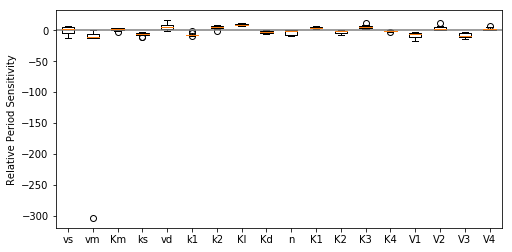

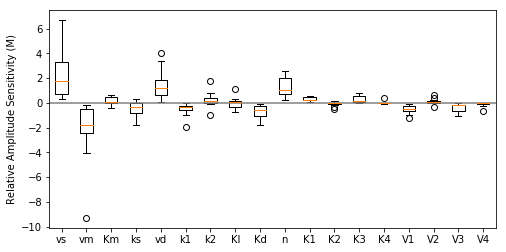

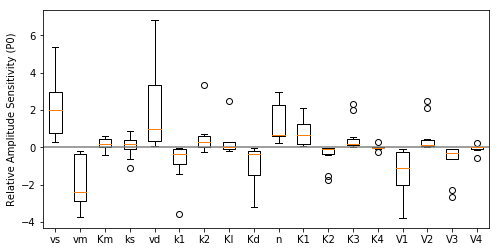

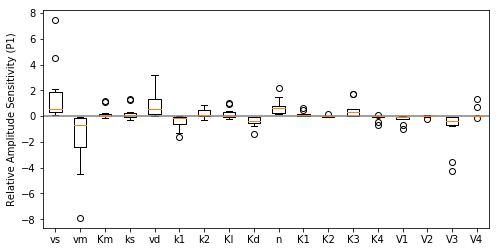

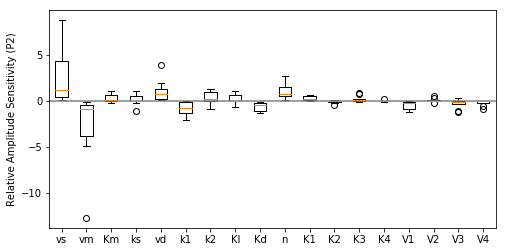

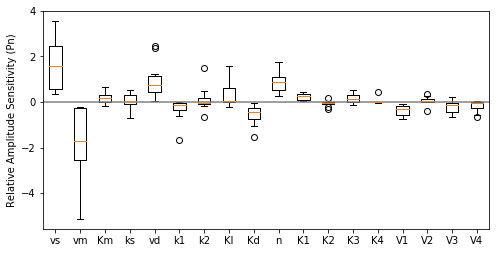

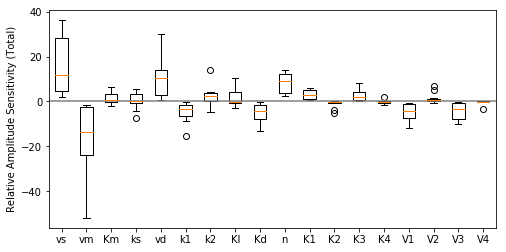

In [12]:
# Start code and write-up here
num_params = good_params.shape[1]
num_runs = good_params.shape[0]

fn = 'fly_clock_sensitivity.npz'

if not os.path.isfile( fn ):
    pRel = np.zeros((num_runs,num_params))
    mRel = np.zeros((num_runs,num_params))
    p0Rel = np.zeros((num_runs,num_params))
    p1Rel = np.zeros((num_runs,num_params))
    p2Rel = np.zeros((num_runs,num_params))
    pnRel = np.zeros((num_runs,num_params))
    aTRel = np.zeros((num_runs,num_params))

    for run_num in range(num_runs):
        pRel[run_num,:] = sensitivity( get_fly_period, np.array(good_params[run_num,:]), 0.05 )
        mRel[run_num,:] = sensitivity( lambda p: get_amplitude( p, which_state = 0), good_params[run_num,:], 0.05 )
        p0Rel[run_num,:] = sensitivity( lambda p: get_amplitude( p, which_state = 1), good_params[run_num,:], 0.05 )
        p1Rel[run_num,:] = sensitivity( lambda p: get_amplitude( p, which_state = 2), good_params[run_num,:], 0.05 )
        p2Rel[run_num,:] = sensitivity( lambda p: get_amplitude( p, which_state = 3), good_params[run_num,:], 0.05 )
        pnRel[run_num,:] = sensitivity( lambda p: get_amplitude( p, which_state = 4), good_params[run_num,:], 0.05 )
        aTRel[run_num,:] = sensitivity( lambda p: get_amplitude( p, which_state = -1), good_params[run_num,:], 0.05 )
    np.savez( fn, pRel=pRel, mRel = mRel, p0Rel=p0Rel, p1Rel=p1Rel, p2Rel=p2Rel, pnRel= pnRel, aTRel=aTRel )

    
else:
    f = np.load( fn )
    pRel = f['pRel']
    mRel = f['mRel']
    p0Rel = f['p0Rel']
    p1Rel = f['p1Rel']
    p2Rel = f['p2Rel']
    pnRel = f['pnRel']
    aTRel = f['aTRel']

plt.figure( figsize=(8,4) )
plt.boxplot( pRel );
plt.axhline(color='gray')
plt.xticks( ticks=np.arange(1,len(param_names)+1), labels=param_names);
plt.ylabel( 'Relative Period Sensitivity')
plt.figure( figsize=(8,4) )
plt.boxplot( mRel );
plt.axhline(color='gray')
plt.xticks( ticks=np.arange(1,len(param_names)+1), labels=param_names);
plt.ylabel( 'Relative Amplitude Sensitivity (M)')
plt.figure( figsize=(8,4) )
plt.boxplot( p0Rel );
plt.axhline(color='gray')
plt.xticks( ticks=np.arange(1,len(param_names)+1), labels=param_names);
plt.ylabel( 'Relative Amplitude Sensitivity (P0)')
plt.figure( figsize=(8,4) )
plt.boxplot( p1Rel );
plt.axhline(color='gray')
plt.xticks( ticks=np.arange(1,len(param_names)+1), labels=param_names);
plt.ylabel( 'Relative Amplitude Sensitivity (P1)');
plt.figure( figsize=(8,4) )
plt.boxplot( p2Rel );
plt.axhline(color='gray')
plt.xticks( ticks=np.arange(1,len(param_names)+1), labels=param_names);
plt.ylabel( 'Relative Amplitude Sensitivity (P2)');
plt.figure( figsize=(8,4) )
plt.boxplot( pnRel );
plt.axhline(color='gray')
plt.xticks( ticks=np.arange(1,len(param_names)+1), labels=param_names);
plt.ylabel( 'Relative Amplitude Sensitivity (Pn)');
plt.figure( figsize=(8,4) )
plt.boxplot( aTRel );
plt.axhline(color='gray')
plt.xticks( ticks=np.arange(1,len(param_names)+1), labels=param_names);
plt.ylabel( 'Relative Amplitude Sensitivity (Total)');

# Analysis

## Sensitivity for pRel
For the period sensitivity of pRel, we noticed that the sensitivity stayed around 0 with an outlier for vm at -300; however, most of the sensitivity output remained at 0 meaning that there was very little influence from the parameters to affect the simulation.

## Sensitivity for mRel
For the sensitivity of mRel, we noticed that vs had the largest sensitivity effect on mRel given that it reached to be a sensitivity of 6 from the run of the array that was fed into function. Similarly, the sensitivity function with vm, vd, and n also provided some impact to the sensitivity with the first parameter providing some negative influence to the amplitude, while vd and n provided some positive influence to the parameter.

## Sensitivity for p0Rel
For the sensitivity of p0Rel, we noticed that 

## Sensitivity for p1Rel

## Sensitivity for p2Rel

## Sensitivity for pnRel

## Sensitivity for aTRel
For the sensitivity of aTRel, the parameter with the largest negative influence to the amplitude was vm while vs and vd provided some positive sensitivity to the amplitude for aTRel.

## Extension : Explore the effects of changing the size of the perturbation used to compute the sensitivities.

<hr style="border:2px solid gray"> </hr>

Acknowledgements

*Replace this text with links to external resources and thanks to people you worked with.*